# Importing Libraries

In [1]:
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, ElasticTransform, Affine, HorizontalFlip, VerticalFlip, ToTensorV2
import os
import random
from PIL import Image, ImageOps
import numpy as np
import cv2
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import json
import pandas as pd

# Bayesian UNet Implementation

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class EncoderBloc(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.5):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(p=dropout_prob)

    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        x_down = self.dropout(x_down)
        return x_down, x_conv

class DecoderBloc(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)


In [3]:
class BayesianUNet(nn.Module):
    def __init__(self, in_channels,num_classes, dropout_prob):
        super().__init__()
        
        # Encoder (Down sampling)
        self.encoder_bloc_1   = EncoderBloc(in_channels, 64, dropout_prob)
        self.encoder_bloc_2   = EncoderBloc(64, 128, dropout_prob)
        self.encoder_bloc_3   = EncoderBloc(128, 256, dropout_prob)
        self.encoder_bloc_4   = EncoderBloc(256, 512, dropout_prob)
        
        # Bottleneck
        self.bottle_neck      = DoubleConv(512, 1024)
        
        # Decoder (Up sampling)
        self.decoder_bloc_1   = DecoderBloc(1024, 512)
        self.decoder_bloc_2   = DecoderBloc(512, 256)
        self.decoder_bloc_3   = DecoderBloc(256, 128)
        self.decoder_bloc_4   = DecoderBloc(128, 64)
        
        # Final 1x1 conv
        self.out              = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x2,x1 = self.encoder_bloc_1(x) 
        x3,x2 = self.encoder_bloc_2(x2)
        x4,x3 = self.encoder_bloc_3(x3)
        x5,x4 = self.encoder_bloc_4(x4)
        
        # Bottleneck
        
        bn = self.bottle_neck(x5)
        
        # Decoder
        u1 = self.decoder_bloc_1(bn, x4)
        u2 = self.decoder_bloc_2(u1, x3)
        u3 = self.decoder_bloc_3(u2, x2)
        u4 = self.decoder_bloc_4(u3, x1)
        
        # Output
        return self.out(u4)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BayesianUNet(in_channels=1, num_classes=5, dropout_prob=0.5).to(device)
x = torch.randn(2, 1, 256, 256).to(device)
preds = model(x)
print(preds.shape)

torch.Size([2, 5, 256, 256])


# Data Loading

In [5]:
Classes = {
    (51, 221, 255): 0,   # ICM
    (250,  50,  83): 1,  # TE
    ( 61, 245,  61): 2,  # ZP
    (255, 245,  61) : 3, # BL
    (  0,   0,   0): 4,   # background
}

TARGET_SIZE = (256, 256)  # (W, H)


#Label Encoding
def mask_encoding(arr):
    h, w, _ = arr.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)
    for rgb, idx in Classes.items():
        class_mask[np.all(arr == rgb, axis=-1)] = idx
    return class_mask


class BlastocystDataset(Dataset):
    def __init__(self, image_dir, mask_dir, seed=None, augment=False):
        self.image_dir       = image_dir
        self.mask_dir        = mask_dir
        self.image_filenames = sorted(os.listdir(image_dir))
        self.augment         = augment
        self.seed            = seed

        if augment:
            self.transform = Compose([
                Affine(
                    rotate=(-90, 90),  # Random rotation between -90 and +90 degrees
                    translate_percent=(-0.1, 0.1),  # Shift by +/- 10%
                    scale=(0.8, 1.2),  # Zoom by +/- 20% (0.8 to 1.2)
                    p=1.0,
                    border_mode=cv2.BORDER_CONSTANT,
                    fill=0,       # image‐pad with 0 → black
                    fill_mask=4,  # mask‐pad with 3 →  background
                    mask_interpolation=cv2.INTER_NEAREST
                ),
                HorizontalFlip(p=0.5),  # 50% horizontal flip
                VerticalFlip(p=0.5),    # 50% vertical flip
                ToTensorV2(),
            ], additional_targets={'mask': 'mask'}, seed=seed)
        else:
            self.transform = Compose([
                ToTensorV2(),
            ], additional_targets={'mask': 'mask'}, seed=seed)
       

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name  = self.image_filenames[idx]
        img_path  = os.path.join(self.image_dir, img_name)
    
        core      = os.path.splitext(img_name)[0]
        mask_path = os.path.join(self.mask_dir, core + ".png")
    
        # load / pad grayscale image
        img = Image.open(img_path).convert("L")
        img = ImageOps.pad(img, TARGET_SIZE, method=Image.BILINEAR, color=0)
        # img = img.resize(TARGET_SIZE, resample=Image.BILINEAR)
        img = np.array(img, np.float32) / 255.0                    # [H,W] float
                                                                   # [1,H,W]
    
        # load / pad mask, then encode to classes
        mask_rgb = Image.open(mask_path).convert("RGB")
        mask_rgb = ImageOps.pad(mask_rgb, TARGET_SIZE, method=Image.NEAREST, color=(0, 0, 0))
        # mask_rgb = mask_rgb.resize(TARGET_SIZE, resample=Image.NEAREST)
        mask_arr = np.array(mask_rgb)
        mask = mask_encoding(mask_arr)                              # [H,W] uint8
                                                                    # int64 for CE-loss
        # Apply transformations (augmentations + ToTensorV2)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask'].long()  # Ensure mask is LongTensor for CrossEntropyLoss
    
        return img, mask, img_name   # img→[1,H,W], mask→[H,W]


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def get_loaders_active(
        train_img_dir,
        train_mask_dir,
        test_img_dir,
        test_mask_dir,
        batch_size,
        seed=None,
        augment = False,
        generator=None,
        num_workers=4,
        pin_memory=True,
):
    # 1. Labeled Dataset (with masks)
    train_ds = BlastocystDataset(
        image_dir=train_img_dir,
        mask_dir=train_mask_dir,
        seed = seed,
        augment = augment
    )

    # 2. Test Dataset (with masks)
    test_ds = BlastocystDataset(
        image_dir=test_img_dir,
        mask_dir=test_mask_dir,
        seed=seed,
        augment = False
    )

    # Create loaders
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        generator=generator,
        worker_init_fn=seed_worker,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=True  # Helps with batch normalization
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        worker_init_fn=seed_worker,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    return train_loader, test_loader

## Verifying the Pre-Processed Images and Masks


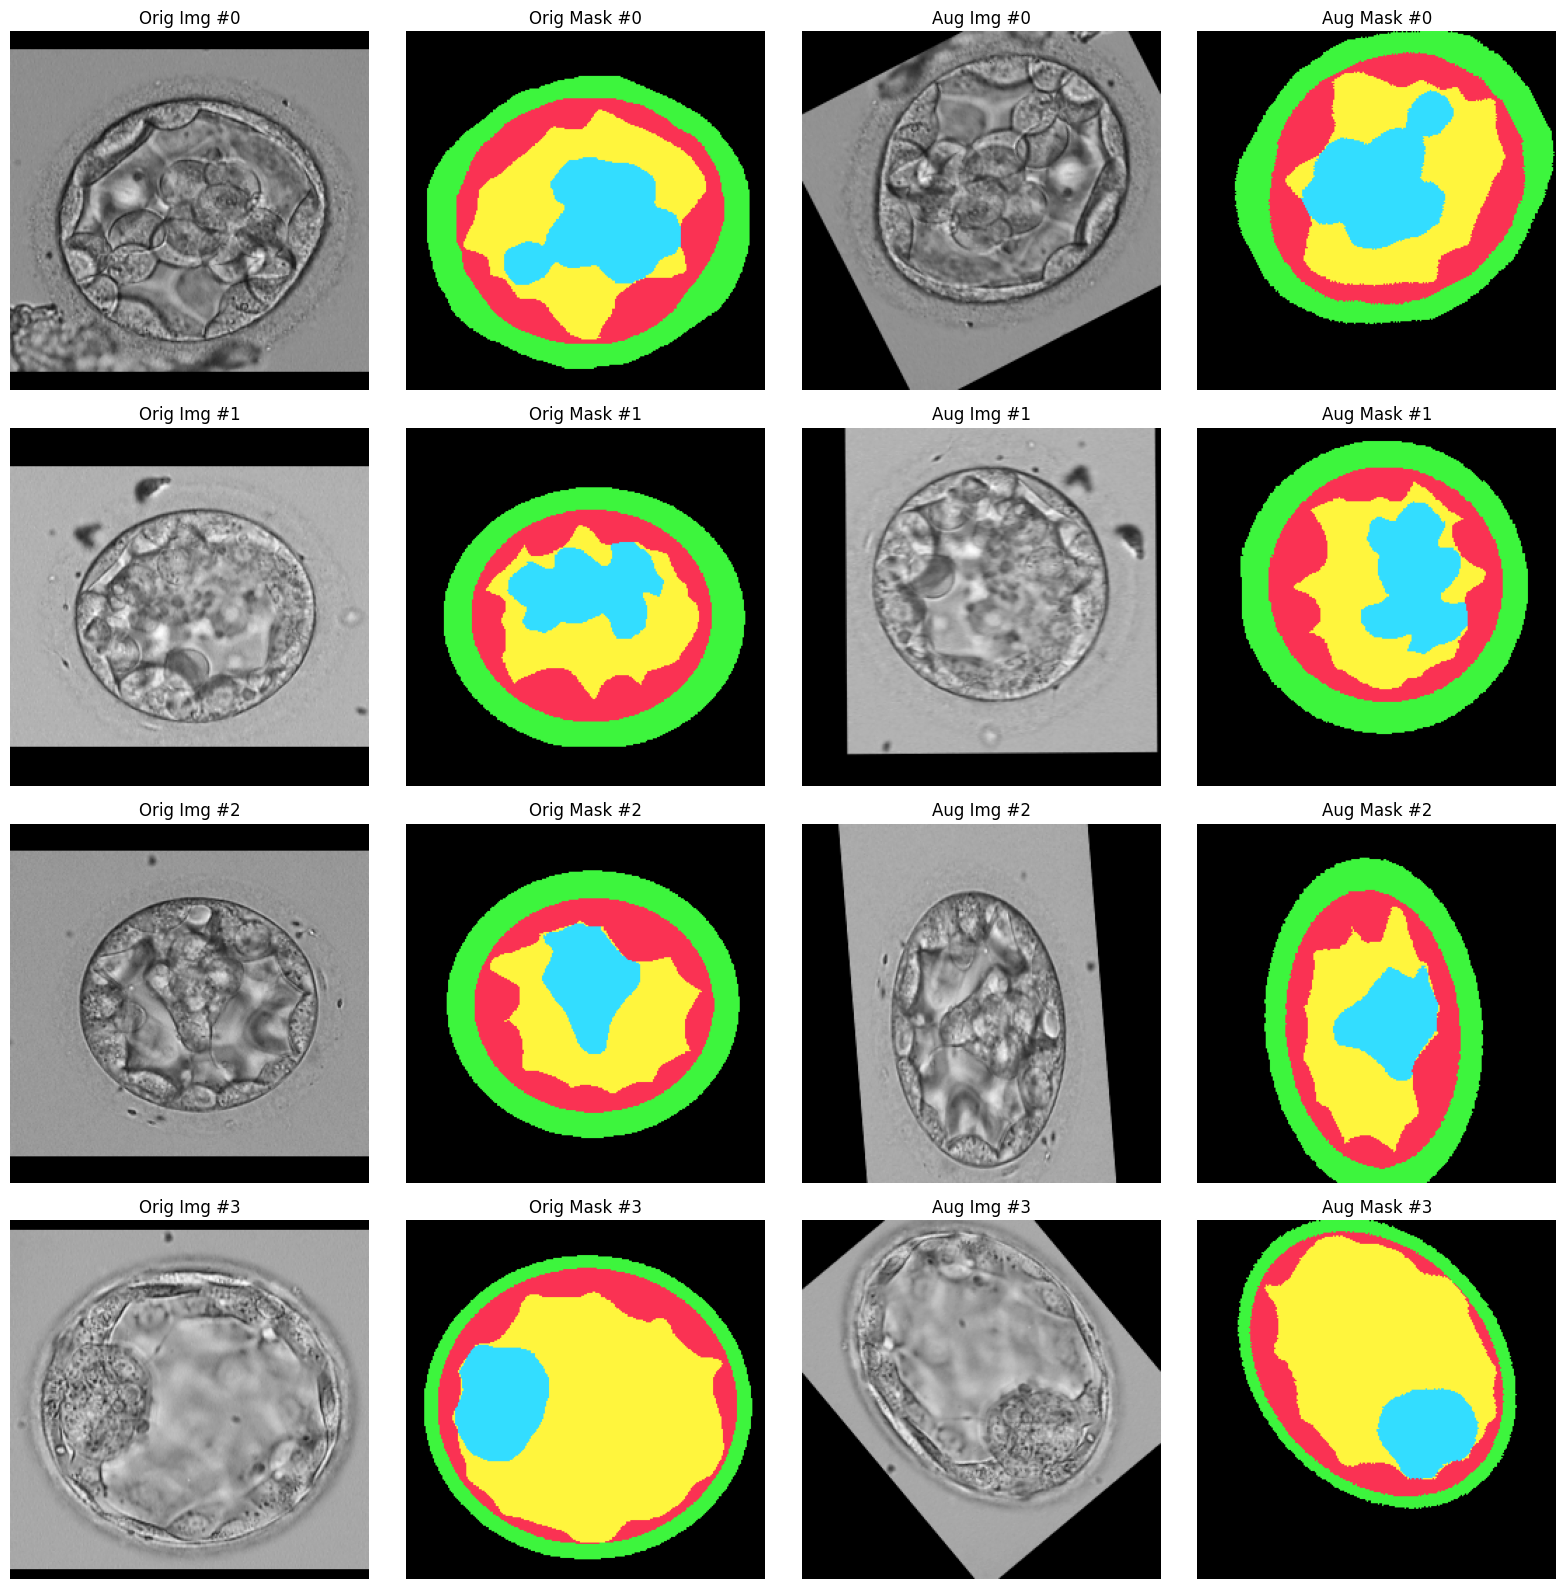

In [6]:
idx2rgb = {idx: rgb for rgb, idx in Classes.items()}

def decode_mask(mask):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for idx, color in idx2rgb.items():
        color_mask[mask == idx] = color
    return color_mask

def show_as_rows(
    image_dir, mask_dir,
    idxs=(0,),           # list of sample indices you want to display
    seed=42,
    figsize_per_panel=(4, 4)
):
    # prepare datasets once
    ds_orig = BlastocystDataset(image_dir, mask_dir, seed=seed, augment=False)
    ds_aug  = BlastocystDataset(image_dir, mask_dir, seed=seed, augment=True)

    n = len(idxs)
    fig, axes = plt.subplots(
        n, 4,
        figsize=(figsize_per_panel[0]*4, figsize_per_panel[1]*n),
        squeeze=False
    )

    for row, idx in enumerate(idxs):
        # fetch
        img_o, mask_o, _ = ds_orig[idx]
        img_a, mask_a, _ = ds_aug[idx]

        # to numpy
        img_o = img_o.squeeze(0).cpu().numpy()
        img_a = img_a.squeeze(0).cpu().numpy()
        mask_o = mask_o.cpu().numpy()
        mask_a = mask_a.cpu().numpy()

        # decode to true colours
        mask_o_rgb = decode_mask(mask_o)
        mask_a_rgb = decode_mask(mask_a)

        # panel 0: original image
        ax = axes[row, 0]
        ax.imshow(img_o, cmap='gray')
        ax.set_title(f'Orig Img #{idx}')
        ax.axis('off')

        # panel 1: original mask
        ax = axes[row, 1]
        ax.imshow(mask_o_rgb)
        ax.set_title(f'Orig Mask #{idx}')
        ax.axis('off')

        # panel 2: augmented image
        ax = axes[row, 2]
        ax.imshow(img_a, cmap='gray')
        ax.set_title(f'Aug Img #{idx}')
        ax.axis('off')

        # panel 3: augmented mask
        ax = axes[row, 3]
        ax.imshow(mask_a_rgb)
        ax.set_title(f'Aug Mask #{idx}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
show_as_rows(
    image_dir='/kaggle/input/blastocyst-dataset/train/images',
    mask_dir ='/kaggle/input/blastocyst-dataset/train/masks',
    idxs=list(range(4)),
    seed=1
)

# Metrics

In [7]:
class TverskyLossNoBG(nn.Module):
    def __init__(self, alpha, beta, smooth=1e-6, bg_idx=4):
        super().__init__()
        self.alpha, self.beta = alpha, beta
        self.smooth = smooth
        self.bg_idx = bg_idx

    def forward(self, logits, target):
        B,C,H,W = logits.shape
        probs   = F.softmax(logits, dim=1)
        oh      = F.one_hot(target.clamp(0,C-1), C).permute(0,3,1,2).float()
        dims    = (0,2,3)
        TP = (probs * oh).sum(dims)
        FP = (probs * (1 - oh)).sum(dims)
        FN = ((1 - probs) * oh).sum(dims)
        # exclude background
        mask = torch.ones(C, dtype=torch.bool, device=logits.device)
        mask[self.bg_idx] = False
        TP,FP,FN = TP[mask], FP[mask], FN[mask]
        TI = (TP + self.smooth) / (TP + self.alpha*FP + self.beta*FN + self.smooth)
        return (1 - TI).mean()

def pixel_accuracy(preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    # preds and targets are of shape (N, H, W)
    correct = (preds == targets).sum() # Shape: ()
    total   = preds.numel()
    return correct.float() / total # Shape: ()

def macro_dice(preds: torch.Tensor,
               targets: torch.Tensor,
               num_classes: int,
               eps: float = 1e-6) -> torch.Tensor:
    # preds and targets are of shape (N, H, W)
    # One-hot encode to (N, H, W, C)
    p_oh = F.one_hot(preds,   num_classes).permute(0,3,1,2).float() # Shape: (N, H, W, C)
    t_oh = F.one_hot(targets, num_classes).permute(0,3,1,2).float() # Shape: (N, H, W, C)

    # Sum over batch+spatial dims → (C,)
    dims = (0, 2, 3)
    inter = (p_oh * t_oh).sum(dims) # Shape: (C,)
    union = p_oh.sum(dims) + t_oh.sum(dims) # Shape: (C,)

    dice_per_class = (2 * inter + eps) / (union + eps) # Shape: (C,)
    return dice_per_class.mean() # Shape: ()


# Train Eval

In [8]:
def train_one_epoch(loader,
                    model,
                    optimizer,
                    loss_fn,
                    device="cuda",
                    scheduler=None,          # any torch.optim.lr_scheduler.*
                    scaler=None,             # GradScaler(); will create one if None
                    num_classes=5):
 
    model.train()                            # Puts modules such as Dropout and BatchNorm into training mode
    device  = torch.device(device)
    scaler  = scaler or GradScaler()         #performance
    tot_loss, tot_acc, tot_dice = 0.0, 0.0, 0.0
    n_batches = 0
    pbar = tqdm(loader, desc="Train", leave=False)
    for imgs, masks, *_ in pbar:
        imgs = imgs.float().to(device, non_blocking=True)
        masks = masks.long().to(device, non_blocking=True) #crossEntorpy expects int64
        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(imgs)  # (N, C, H, W)
            loss = loss_fn(logits, masks)  # scalar

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        if scheduler and not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step()

        with torch.no_grad():
            preds = logits.argmax(dim=1)     # label map (N, H, W)

            batch_acc = pixel_accuracy(preds, masks)
            batch_dice = macro_dice(preds, masks, num_classes)

        n_batches += 1
        tot_loss += loss.item()
        tot_acc += batch_acc.item()
        tot_dice += batch_dice.item()

        pbar.set_postfix({
            "loss": tot_loss / n_batches,
            "acc%": (tot_acc / n_batches) * 100,
            "dice": tot_dice / n_batches,
            "lr": optimizer.param_groups[0]["lr"]
        })

    pbar.close()

    if scheduler and isinstance(scheduler,
                                torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(tot_loss / n_batches)

    mean_loss = tot_loss / n_batches
    mean_acc = tot_acc / n_batches * 100.0
    mean_dice = tot_dice / n_batches
    return mean_loss, mean_acc, mean_dice

@torch.no_grad()
def evaluate_loader(loader, model, loss_fn, device="cuda", num_classes=5):
    model.eval()                               # inference mode
    device  = torch.device(device)

    tot_loss, tot_acc, tot_dice, n_batches = 0.0, 0.0, 0.0, 0

    pbar = tqdm(loader, desc="Eval", leave=False)
    for imgs, masks, *_ in pbar:
        imgs  = imgs.float().to(device, non_blocking=True)
        masks = masks.long().to(device, non_blocking=True)

        logits = model(imgs)                   # (N, C, H, W)
        batch_loss = loss_fn(logits, masks)
        preds  = logits.argmax(1)              # (N, H, W)

        batch_acc = pixel_accuracy(preds, masks)
        batch_dice = macro_dice(preds, masks, num_classes)

        # accumulate
        tot_loss += batch_loss.item()
        tot_acc  += batch_acc.item()
        tot_dice += batch_dice.item()
        n_batches += 1

        pbar.set_postfix({"acc%": tot_acc/n_batches,
                          "dice": tot_dice/n_batches})
    pbar.close()

    if n_batches == 0:
        raise ValueError("Loader is empty – nothing to evaluate.")

    return tot_loss / n_batches ,tot_acc / n_batches, tot_dice / n_batches

# Training The Model

In [9]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
g = torch.Generator().manual_seed(seed)

In [10]:
# Model 1 
# 0) Config
num_classes   = 5
device        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patience      = 15         # early stopping on val_dice
batch_size    = 16
min_delta     = 1e-4
initial_lr    = 1e-3
max_epochs    = 100
bg_idx        = 4          # background class index
augment = True

# Hyperparameters for CE + FocalTversky
alpha         = 0.3
beta          = 0.7
lambda_ft     = 1       # weight for the Focal-Tversky term

# Paths
work_dir      = "/kaggle/working"
os.makedirs(work_dir, exist_ok=True)



# directories
base_dir       = Path("/kaggle") / "input" / "blastocyst-dataset"
train_img_dir  = base_dir / "train" / "images"
train_mask_dir = base_dir / "train" / "masks"
test_img_dir   = base_dir / "test"  / "images"
test_mask_dir  = base_dir / "test"  / "masks"

# data loaders
train_loader, test_loader = get_loaders_active(
    str(train_img_dir),
    str(train_mask_dir),
    str(test_img_dir),
    str(test_mask_dir),
    batch_size=batch_size,
    seed=seed,
    augment=augment,
    generator=g,
    num_workers=4,
    pin_memory=True
)

# ————————————————Class Weights——————————————————————————————
class_counts = torch.zeros(num_classes, dtype=torch.float32, device=device)
total_pixels = 0
for imgs, masks, _ in train_loader:
    flat = masks.view(-1)
    class_counts += torch.bincount(flat, minlength=num_classes).float().to(device)
    total_pixels += flat.numel()

class_freqs = class_counts / total_pixels
median_freq = torch.median(class_freqs)
class_weights = median_freq / class_freqs
# Optional normalisation so mean(weight)==1
class_weights = class_weights / class_weights.mean()
# ——————————————————————————————————————————————————————————
# 3) Define losses

tversky_fn = TverskyLossNoBG(alpha, beta, bg_idx=bg_idx).to(device)
ce_loss = nn.CrossEntropyLoss(weight=class_weights)


# Modify combined_loss
def combined_loss(logits, targets):
    ce = ce_loss(logits, targets)
    tv = tversky_fn(logits, targets)
    return ce + tv

# ——————————————————————————————————————————————————————————
# 4) Model, optimizer, scaler
model     = BayesianUNet(in_channels=1, num_classes=num_classes, dropout_prob=0.3).to(device)
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-4)
scaler    = GradScaler()

# ——————————————————————————————————————————————————————————
# 5) Training loop (no scheduler)
history  = {'epoch':[], 'train_loss':[], 'val_loss':[], 'train_dice':[], 'val_dice':[]}
best_val = -float('inf')
wait     = 0

for epoch in range(1, max_epochs+1):
    # --- training ---
    tr_loss, tr_acc, tr_dice = train_one_epoch(
        train_loader, model, optimizer, combined_loss,
        device=device, scheduler=None, scaler=scaler,
        num_classes=num_classes
    )

    # --- validation ---
    val_loss, val_acc, val_dice = evaluate_loader(
        test_loader, model, combined_loss,
        device=device, num_classes=num_classes
    )

    # --- logging ---
    history['epoch'].append(epoch)
    history['train_loss'].append(tr_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(tr_dice)
    history['val_dice'].append(val_dice)

    curr_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:03d} | lr={curr_lr:.1e} "
          f"| tr_loss={tr_loss:.4f}, tr_dice={tr_dice:.4f} "
          f"| val_loss={val_loss:.4f}, val_dice={val_dice:.4f}")

    # early stopping on val_dice
    if val_dice > best_val:
        best_val = val_dice
        torch.save(model.state_dict(), os.path.join(work_dir, "model.pth"))
# ——————————————————————————————————————————————————————————
# 6) Save history
with open(os.path.join(work_dir, "model_history.json"), 'w') as f:
    json.dump(history, f, indent=2)

print("Training complete. Model and logs saved to", work_dir)

/tmp/ipykernel_36/1959658745.py:75: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
Train:   0%|          | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_36/3741268666.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 001 | lr=1.0e-03 | tr_loss=1.9935, tr_dice=0.4033 | val_loss=2.5829, val_dice=0.0872


Epoch 002 | lr=1.0e-03 | tr_loss=1.5562, tr_dice=0.5408 | val_loss=4.3059, val_dice=0.1210


Epoch 003 | lr=1.0e-03 | tr_loss=1.1674, tr_dice=0.6833 | val_loss=5.5388, val_dice=0.1930


Epoch 004 | lr=1.0e-03 | tr_loss=0.9993, tr_dice=0.7271 | val_loss=2.8286, val_dice=0.3766


Epoch 005 | lr=1.0e-03 | tr_loss=0.9384, tr_dice=0.7483 | val_loss=1.5239, val_dice=0.6025


Epoch 006 | lr=1.0e-03 | tr_loss=0.8967, tr_dice=0.7569 | val_loss=1.0497, val_dice=0.7159


Epoch 007 | lr=1.0e-03 | tr_loss=0.7794, tr_dice=0.7888 | val_loss=1.0500, val_dice=0.7247


Epoch 008 | lr=1.0e-03 | tr_loss=0.7703, tr_dice=0.7869 | val_loss=0.7855, val_dice=0.7833


Epoch 009 | lr=1.0e-03 | tr_loss=0.8037, tr_dice=0.7779 | val_loss=0.7994, val_dice=0.7861


Epoch 010 | lr=1.0e-03 | tr_loss=0.7565, tr_dice=0.7927 | val_loss=0.6824, val_dice=0.7945


Epoch 011 | lr=1.0e-03 | tr_loss=0.6821, tr_dice=0.8119 | val_loss=0.7285, val_dice=0.7766


Epoch 012 | lr=1.0e-03 | tr_loss=0.6976, tr_dice=0.8043 | val_loss=0.9269, val_dice=0.7412


Epoch 013 | lr=1.0e-03 | tr_loss=0.6799, tr_dice=0.8084 | val_loss=0.8115, val_dice=0.7203


Epoch 014 | lr=1.0e-03 | tr_loss=0.6500, tr_dice=0.8189 | val_loss=0.7605, val_dice=0.7713


Epoch 015 | lr=1.0e-03 | tr_loss=0.6451, tr_dice=0.8135 | val_loss=0.8548, val_dice=0.6943


Epoch 016 | lr=1.0e-03 | tr_loss=0.6446, tr_dice=0.8192 | val_loss=0.6086, val_dice=0.8163


Epoch 017 | lr=1.0e-03 | tr_loss=0.6471, tr_dice=0.8174 | val_loss=0.7851, val_dice=0.7631


Epoch 018 | lr=1.0e-03 | tr_loss=0.6318, tr_dice=0.8257 | val_loss=0.8602, val_dice=0.7380


Epoch 019 | lr=1.0e-03 | tr_loss=0.6289, tr_dice=0.8226 | val_loss=0.6802, val_dice=0.7835


Epoch 020 | lr=1.0e-03 | tr_loss=0.6157, tr_dice=0.8232 | val_loss=0.6053, val_dice=0.8086


Epoch 021 | lr=1.0e-03 | tr_loss=0.5880, tr_dice=0.8347 | val_loss=0.8340, val_dice=0.7788


Epoch 022 | lr=1.0e-03 | tr_loss=0.6051, tr_dice=0.8263 | val_loss=0.5473, val_dice=0.8496


Epoch 023 | lr=1.0e-03 | tr_loss=0.5819, tr_dice=0.8358 | val_loss=0.6010, val_dice=0.8427


Epoch 024 | lr=1.0e-03 | tr_loss=0.5704, tr_dice=0.8380 | val_loss=0.5366, val_dice=0.8563


Epoch 025 | lr=1.0e-03 | tr_loss=0.5764, tr_dice=0.8365 | val_loss=0.5375, val_dice=0.8600


Epoch 026 | lr=1.0e-03 | tr_loss=0.5748, tr_dice=0.8342 | val_loss=0.5616, val_dice=0.8635


Epoch 027 | lr=1.0e-03 | tr_loss=0.5543, tr_dice=0.8446 | val_loss=0.5434, val_dice=0.8447


Epoch 028 | lr=1.0e-03 | tr_loss=0.5414, tr_dice=0.8452 | val_loss=0.6114, val_dice=0.7941


Epoch 029 | lr=1.0e-03 | tr_loss=0.5369, tr_dice=0.8457 | val_loss=0.5788, val_dice=0.8020


Epoch 030 | lr=1.0e-03 | tr_loss=0.5393, tr_dice=0.8436 | val_loss=0.5190, val_dice=0.8427


Epoch 031 | lr=1.0e-03 | tr_loss=0.5412, tr_dice=0.8439 | val_loss=0.6327, val_dice=0.7775


Epoch 032 | lr=1.0e-03 | tr_loss=0.5340, tr_dice=0.8487 | val_loss=0.6023, val_dice=0.7980


Epoch 033 | lr=1.0e-03 | tr_loss=0.5698, tr_dice=0.8378 | val_loss=0.9969, val_dice=0.6948


Epoch 034 | lr=1.0e-03 | tr_loss=0.5738, tr_dice=0.8399 | val_loss=0.5749, val_dice=0.8399


Epoch 035 | lr=1.0e-03 | tr_loss=0.5437, tr_dice=0.8456 | val_loss=0.6978, val_dice=0.8422


Epoch 036 | lr=1.0e-03 | tr_loss=0.5771, tr_dice=0.8381 | val_loss=0.5607, val_dice=0.8533


Epoch 037 | lr=1.0e-03 | tr_loss=0.5528, tr_dice=0.8408 | val_loss=0.6194, val_dice=0.8319


Epoch 038 | lr=1.0e-03 | tr_loss=0.5504, tr_dice=0.8423 | val_loss=0.5077, val_dice=0.8705


Epoch 039 | lr=1.0e-03 | tr_loss=0.5286, tr_dice=0.8494 | val_loss=0.5371, val_dice=0.8700


Epoch 040 | lr=1.0e-03 | tr_loss=0.5219, tr_dice=0.8496 | val_loss=0.6250, val_dice=0.8414


Epoch 041 | lr=1.0e-03 | tr_loss=0.5121, tr_dice=0.8518 | val_loss=0.5397, val_dice=0.8129


Epoch 042 | lr=1.0e-03 | tr_loss=0.5094, tr_dice=0.8529 | val_loss=0.5083, val_dice=0.8399


Epoch 043 | lr=1.0e-03 | tr_loss=0.5164, tr_dice=0.8546 | val_loss=0.5402, val_dice=0.8668


Epoch 044 | lr=1.0e-03 | tr_loss=0.4839, tr_dice=0.8595 | val_loss=0.5804, val_dice=0.8174


Epoch 045 | lr=1.0e-03 | tr_loss=0.4985, tr_dice=0.8554 | val_loss=0.4792, val_dice=0.8459


Epoch 046 | lr=1.0e-03 | tr_loss=0.5058, tr_dice=0.8566 | val_loss=0.5497, val_dice=0.8190


Epoch 047 | lr=1.0e-03 | tr_loss=0.5120, tr_dice=0.8517 | val_loss=0.4584, val_dice=0.8532


Epoch 048 | lr=1.0e-03 | tr_loss=0.4867, tr_dice=0.8610 | val_loss=0.4820, val_dice=0.8622


Epoch 049 | lr=1.0e-03 | tr_loss=0.5208, tr_dice=0.8548 | val_loss=0.5916, val_dice=0.8024


Epoch 050 | lr=1.0e-03 | tr_loss=0.5186, tr_dice=0.8536 | val_loss=0.5286, val_dice=0.8466


Epoch 051 | lr=1.0e-03 | tr_loss=0.5199, tr_dice=0.8512 | val_loss=0.6139, val_dice=0.7976


Epoch 052 | lr=1.0e-03 | tr_loss=0.5129, tr_dice=0.8542 | val_loss=0.7231, val_dice=0.7472


Epoch 053 | lr=1.0e-03 | tr_loss=0.5205, tr_dice=0.8505 | val_loss=0.6764, val_dice=0.7650


Epoch 054 | lr=1.0e-03 | tr_loss=0.5081, tr_dice=0.8544 | val_loss=0.5431, val_dice=0.8445


Epoch 055 | lr=1.0e-03 | tr_loss=0.4845, tr_dice=0.8631 | val_loss=0.6301, val_dice=0.7742


Epoch 056 | lr=1.0e-03 | tr_loss=0.4758, tr_dice=0.8639 | val_loss=0.7407, val_dice=0.7529


Epoch 057 | lr=1.0e-03 | tr_loss=0.4699, tr_dice=0.8649 | val_loss=0.5484, val_dice=0.8027


Epoch 058 | lr=1.0e-03 | tr_loss=0.4730, tr_dice=0.8642 | val_loss=0.5223, val_dice=0.8235


Epoch 059 | lr=1.0e-03 | tr_loss=0.4570, tr_dice=0.8694 | val_loss=0.5814, val_dice=0.7961


Epoch 060 | lr=1.0e-03 | tr_loss=0.4925, tr_dice=0.8643 | val_loss=0.9471, val_dice=0.7812


Epoch 061 | lr=1.0e-03 | tr_loss=0.5185, tr_dice=0.8528 | val_loss=0.7174, val_dice=0.7544


Epoch 062 | lr=1.0e-03 | tr_loss=0.4912, tr_dice=0.8607 | val_loss=0.5566, val_dice=0.8248


Epoch 063 | lr=1.0e-03 | tr_loss=0.4888, tr_dice=0.8588 | val_loss=0.5425, val_dice=0.8464


Epoch 064 | lr=1.0e-03 | tr_loss=0.4682, tr_dice=0.8650 | val_loss=0.5604, val_dice=0.8730


Epoch 065 | lr=1.0e-03 | tr_loss=0.4661, tr_dice=0.8666 | val_loss=0.4439, val_dice=0.8694


Epoch 066 | lr=1.0e-03 | tr_loss=0.4690, tr_dice=0.8662 | val_loss=0.4549, val_dice=0.8592


Epoch 067 | lr=1.0e-03 | tr_loss=0.4492, tr_dice=0.8689 | val_loss=0.4977, val_dice=0.8406


Epoch 068 | lr=1.0e-03 | tr_loss=0.4460, tr_dice=0.8706 | val_loss=0.4780, val_dice=0.8770


Epoch 069 | lr=1.0e-03 | tr_loss=0.4487, tr_dice=0.8718 | val_loss=0.6953, val_dice=0.7503


Epoch 070 | lr=1.0e-03 | tr_loss=0.4655, tr_dice=0.8667 | val_loss=0.4923, val_dice=0.8412


Epoch 071 | lr=1.0e-03 | tr_loss=0.4581, tr_dice=0.8665 | val_loss=0.5826, val_dice=0.8093


Epoch 072 | lr=1.0e-03 | tr_loss=0.4559, tr_dice=0.8720 | val_loss=0.8322, val_dice=0.7296


Epoch 073 | lr=1.0e-03 | tr_loss=0.4337, tr_dice=0.8745 | val_loss=0.4617, val_dice=0.8555


Epoch 074 | lr=1.0e-03 | tr_loss=0.4459, tr_dice=0.8700 | val_loss=0.4516, val_dice=0.8810


Epoch 075 | lr=1.0e-03 | tr_loss=0.4446, tr_dice=0.8716 | val_loss=0.4519, val_dice=0.8794


Epoch 076 | lr=1.0e-03 | tr_loss=0.4366, tr_dice=0.8752 | val_loss=0.4729, val_dice=0.8684


Epoch 077 | lr=1.0e-03 | tr_loss=0.4404, tr_dice=0.8754 | val_loss=0.5057, val_dice=0.8608


Epoch 078 | lr=1.0e-03 | tr_loss=0.4265, tr_dice=0.8781 | val_loss=0.4487, val_dice=0.8640


Epoch 079 | lr=1.0e-03 | tr_loss=0.4277, tr_dice=0.8762 | val_loss=0.4243, val_dice=0.8789


Epoch 080 | lr=1.0e-03 | tr_loss=0.4208, tr_dice=0.8793 | val_loss=0.5851, val_dice=0.8092


Epoch 081 | lr=1.0e-03 | tr_loss=0.4219, tr_dice=0.8767 | val_loss=0.4856, val_dice=0.8370


Epoch 082 | lr=1.0e-03 | tr_loss=0.4286, tr_dice=0.8771 | val_loss=0.4136, val_dice=0.8938


Epoch 083 | lr=1.0e-03 | tr_loss=0.4351, tr_dice=0.8755 | val_loss=0.6221, val_dice=0.8200


Epoch 084 | lr=1.0e-03 | tr_loss=0.4330, tr_dice=0.8772 | val_loss=0.5976, val_dice=0.8180


Epoch 085 | lr=1.0e-03 | tr_loss=0.4539, tr_dice=0.8709 | val_loss=0.5642, val_dice=0.8238


Epoch 086 | lr=1.0e-03 | tr_loss=0.4260, tr_dice=0.8773 | val_loss=0.4198, val_dice=0.8706


Epoch 087 | lr=1.0e-03 | tr_loss=0.4337, tr_dice=0.8786 | val_loss=0.5019, val_dice=0.8476


Epoch 088 | lr=1.0e-03 | tr_loss=0.4403, tr_dice=0.8722 | val_loss=0.5507, val_dice=0.8188


Epoch 089 | lr=1.0e-03 | tr_loss=0.4248, tr_dice=0.8760 | val_loss=0.4819, val_dice=0.8379


Epoch 090 | lr=1.0e-03 | tr_loss=0.4390, tr_dice=0.8741 | val_loss=1.0337, val_dice=0.7582


Epoch 091 | lr=1.0e-03 | tr_loss=0.4869, tr_dice=0.8613 | val_loss=0.7502, val_dice=0.8085


Epoch 092 | lr=1.0e-03 | tr_loss=0.4684, tr_dice=0.8669 | val_loss=0.5795, val_dice=0.7917


Epoch 093 | lr=1.0e-03 | tr_loss=0.4617, tr_dice=0.8687 | val_loss=0.4662, val_dice=0.8494


Epoch 094 | lr=1.0e-03 | tr_loss=0.4436, tr_dice=0.8723 | val_loss=0.4692, val_dice=0.8401


Epoch 095 | lr=1.0e-03 | tr_loss=0.4382, tr_dice=0.8743 | val_loss=0.4129, val_dice=0.8798


Epoch 096 | lr=1.0e-03 | tr_loss=0.4222, tr_dice=0.8796 | val_loss=0.4512, val_dice=0.8801


Epoch 097 | lr=1.0e-03 | tr_loss=0.4246, tr_dice=0.8789 | val_loss=0.4946, val_dice=0.8341


Epoch 098 | lr=1.0e-03 | tr_loss=0.4034, tr_dice=0.8832 | val_loss=0.5345, val_dice=0.8080


Epoch 099 | lr=1.0e-03 | tr_loss=0.4165, tr_dice=0.8815 | val_loss=0.4123, val_dice=0.8948


Epoch 100 | lr=1.0e-03 | tr_loss=0.4205, tr_dice=0.8768 | val_loss=0.4388, val_dice=0.8603
Training complete. Model and logs saved to /kaggle/working


## Verifying the Results of the training

In [11]:
# Load models
def show_predictions(Classes, model_paths, loader):
    
    # Reverse the Classes dict (label→RGB)
    label2rgb = {idx: rgb for rgb, idx in Classes.items()}
    
    def decode_mask(mask: np.ndarray) -> np.ndarray:
        h, w = mask.shape
        rgb = np.zeros((h, w, 3), dtype=np.uint8)
        for label, color in label2rgb.items():
            rgb[mask == label] = color
        return rgb
    
    # Load your models
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    models = []
    for path in model_paths:
        model = BayesianUNet(in_channels=1, num_classes=5, dropout_prob=0.1).to(device)
        state_dict = torch.load(path, map_location=device)
        model.load_state_dict(state_dict)
        model.eval()
        models.append(model)
    
    # Start inference loop
    with torch.no_grad():
        for batch_idx, (images, masks, names) in enumerate(loader):
            images = images.to(device)                  # [B, 1, H, W]
            masks_np = masks.cpu().numpy()              # [B, H, W]
            images_np = images.cpu().numpy()            # [B, 1, H, W]
    
            B = images_np.shape[0]
            num_models = len(models)
    
            fig, axes = plt.subplots(B, 2 + num_models, figsize=(3*(2 + num_models), 3*B))
    
            # If batch size is 1, ensure axes shape consistency
            if B == 1:
                axes = np.expand_dims(axes, 0)
    
            for i in range(B):
                img = images_np[i].squeeze()
                gt = decode_mask(masks_np[i])
    
                axes[i, 0].imshow(img, cmap="gray")
                axes[i, 0].set_title(f"Input ({names[i]})")
                axes[i, 1].imshow(gt)
                axes[i, 1].set_title("Ground Truth")
    
                # Predictions from each model
                for m_idx, model in enumerate(models):
                    logits = model(images[i].unsqueeze(0))  # [1, C, H, W]
                    preds = torch.argmax(logits, dim=1).cpu().numpy()[0]
                    pr = decode_mask(preds)
    
                    axes[i, m_idx + 2].imshow(pr)
                    model_name = model_paths[m_idx].split('/')[-1].replace('.pth', '')
                    axes[i, m_idx + 2].set_title(f"Pred: {model_name}")
    
                # Hide axes
                for ax in axes[i]:
                    ax.axis("off")
    
            plt.suptitle(f"Batch {batch_idx + 1}", fontsize=16, y=1.02)
            plt.tight_layout()
            plt.show()

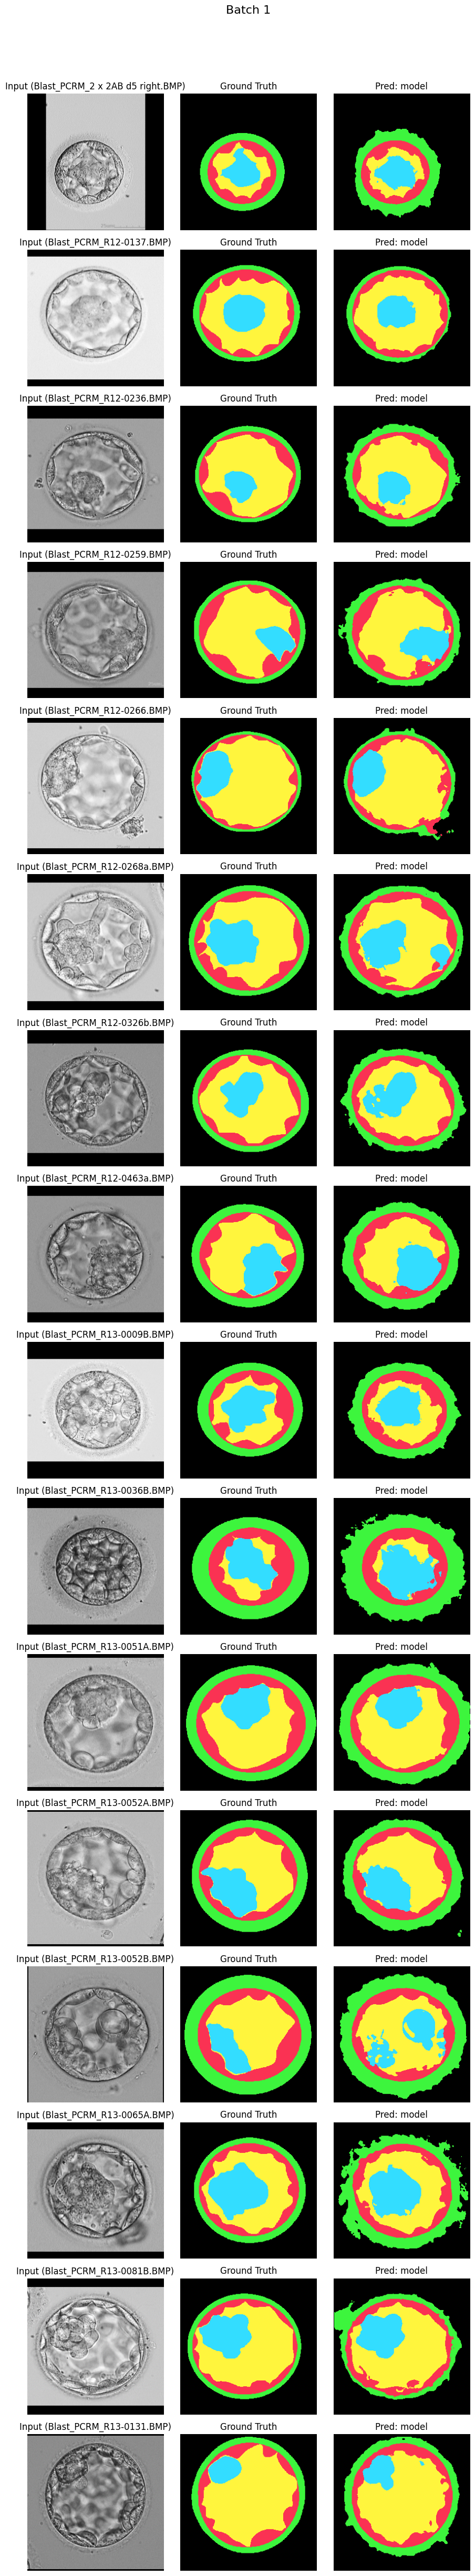

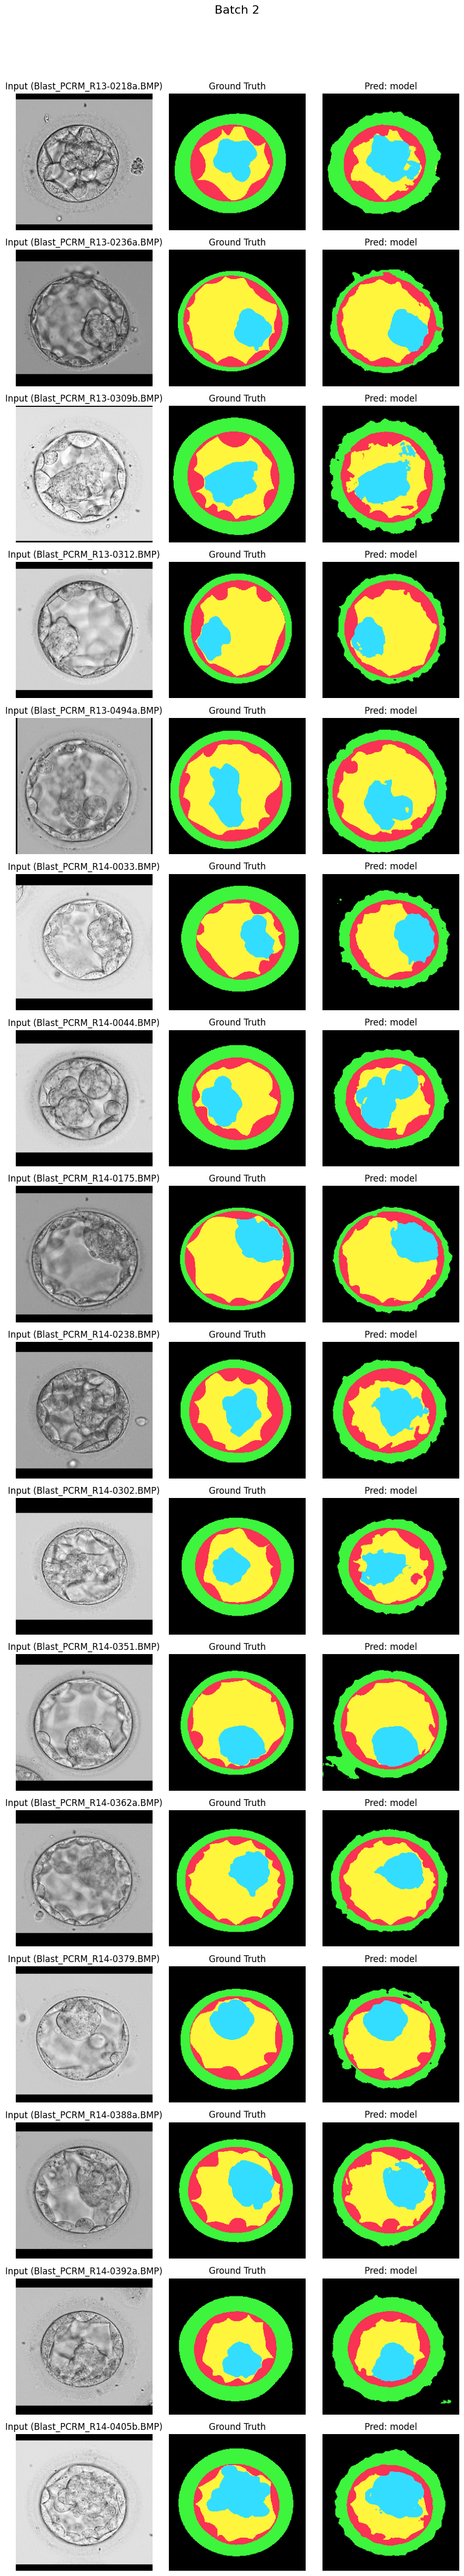

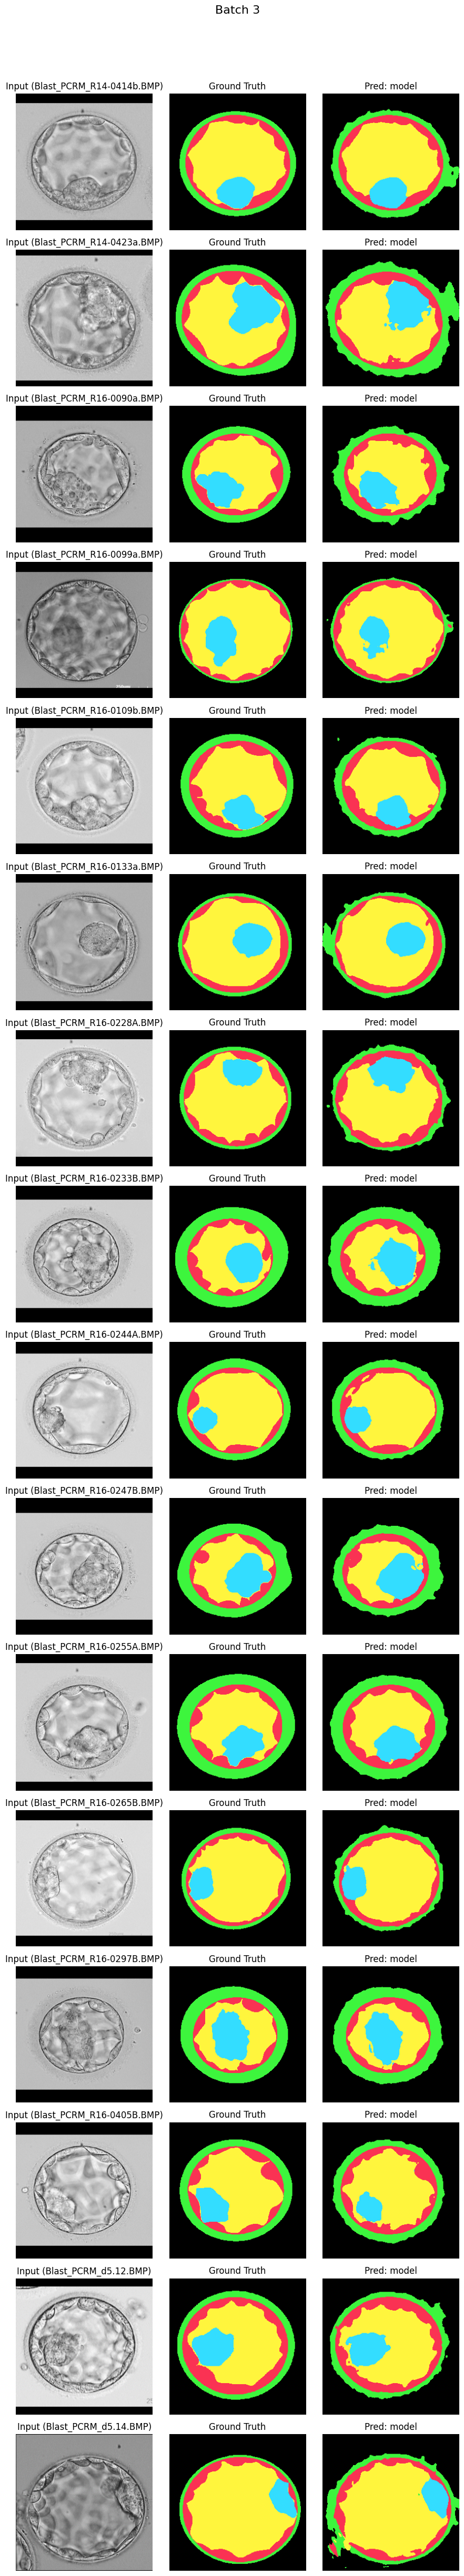

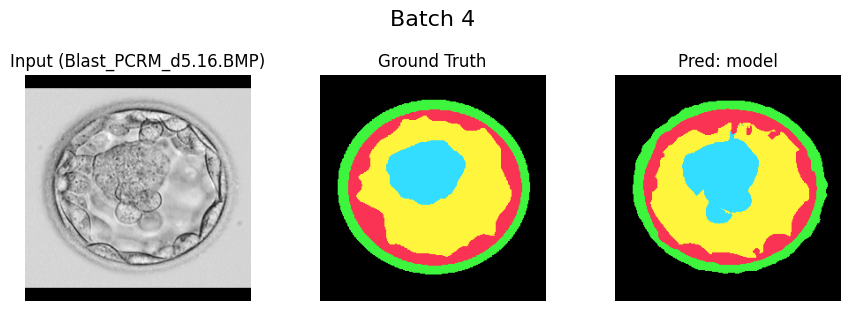

In [12]:
show_predictions(Classes, ['model.pth'] ,test_loader)

In [16]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

def plot_models_grid(json_paths, model_names=None):
    json_paths = [Path(p) for p in json_paths]
    if model_names is None:
        model_names = [p.stem for p in json_paths]
    assert len(json_paths) == len(model_names), "json_paths and model_names length mismatch"

    n_models = len(json_paths)
    fig, axes = plt.subplots(
        2, n_models,
        figsize=(4 * n_models, 6),
        sharex='col',
        sharey='row',
        squeeze=False
    )

    for col, (jp, name) in enumerate(zip(json_paths, model_names)):
        with open(jp, "r") as f:
            m = json.load(f)

        epochs     = m["epoch"]
        train_loss = m["train_loss"]
        val_loss   = m["val_loss"]
        train_dice = m["train_dice"]
        val_dice   = m["val_dice"]

        # Row 0  –  Loss
        ax = axes[0, col]
        ax.plot(epochs, train_loss, label="Train loss")
        ax.plot(epochs, val_loss,   label="Val loss")
        ax.set_title(name)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss" if col == 0 else "")
        ax.grid(True)
        if col == 0:
            ax.legend()

        # Row 1  –  Dice
        ax = axes[1, col]
        ax.plot(epochs, train_dice, label="Train Dice")
        ax.plot(epochs, val_dice,   label="Val Dice")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Dice" if col == 0 else "")
        ax.grid(True)
        if col == 0:
            ax.legend()

    plt.tight_layout()
    plt.show()

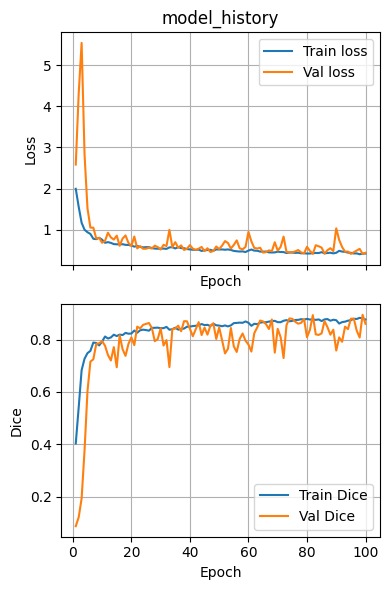

In [19]:
json_path = '/kaggle/working/model_history.json'

plot_models_grid([json_path])